In [50]:
import os
os.environ['PATH'] = os.environ['CONDA_PREFIX']+'/bin:'+os.environ['PATH']
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
import scipy.stats as sts
import warnings

In [2]:
from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy.stats import ttest_ind

In [3]:
%matplotlib inline
# figure size & color
matplotlib.rcParams['figure.dpi'] = 100 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
matplotlib.rcParams['figure.figsize'] = [8, 8] # Square
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "on"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "on"
matplotlib.rcParams['axes.spines.right'] = "off"
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [4]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 2 #set the value globally

In [5]:
def getCoverage(bed, peakfile):
    '''
    Takes in bedfile and peakfile and computes number of reads in the bed file that overlap with a
    peak file. 
    
    Args:
        bed (str): path to fragment file
        peakfile (str): path to peak file
        
    Returns:    
        norm_counts (np.array): an array of normalized counts
        
    '''
    
    frag = BedTool(bed) 
    peaks = BedTool(peakfile)
    inter = peaks.coverage(frag, counts=True)
    
    norm_counts = np.zeros(peaks.count())
    for k, interval in enumerate(inter):
        rd = interval.fields
        norm_counts[k] = rd[-1]
    
    # normalizes by total fragment counts per million
    norm_counts /= frag.count()
    norm_counts *= 1000000
    # logs-scale data
    norm_counts = np.log(norm_counts + 1)
    return norm_counts

In [11]:
data_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/DJ_Hs_PBMC_220523_79x79/bgzip_beds_ArchRmerge_220523_22057/SEACR/FDR_0.01/'
K27 = pd.read_csv(data_dir + 'DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527.stringent.bed', sep='\t', header = None)
K4 = pd.read_csv(data_dir + 'DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527.stringent.bed', sep='\t', header = None)
#label columns
K27.columns = ['chr','str', 'end', 'total','max','summit' ]
K4.columns = ['chr','str', 'end', 'total','max','summit' ]
#calc widths
K27['log_width'] = np.log10(K27['end'] - K27['str']) 
K4['log_width'] = np.log10(K4['end'] - K4['str']) 
#label dfs
K27['mark'] = 'H3K27me3'
K4['mark'] = 'H3K4me123'
K27['bed'] = 'H3K4me123'
K4['bed'] = 'H3K27me3'

In [12]:
#RIPs
# path to list of bed files
bed_K27 = data_dir + '../../DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527.bed'
bed_K4 = data_dir + '../../DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527.bed'

# path to peak or genome binds
peaks_K27 = data_dir + 'DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527.stringent.bed'
peaks_K4 = data_dir + 'DJ_Hs_PBMC_K4me123_ALLSEQ_220523_220527.stringent.bed'

#get reads-in-peaks
K27['RIPs_K27'] = getCoverage(bed_K27, peaks_K27)
K27['RIPs_K4'] = getCoverage(bed_K4, peaks_K27)
K4['RIPs_K27'] = getCoverage(bed_K27, peaks_K4)
K4['RIPs_K4'] = getCoverage(bed_K4, peaks_K4)

In [8]:
fig_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Figures/Sup/'

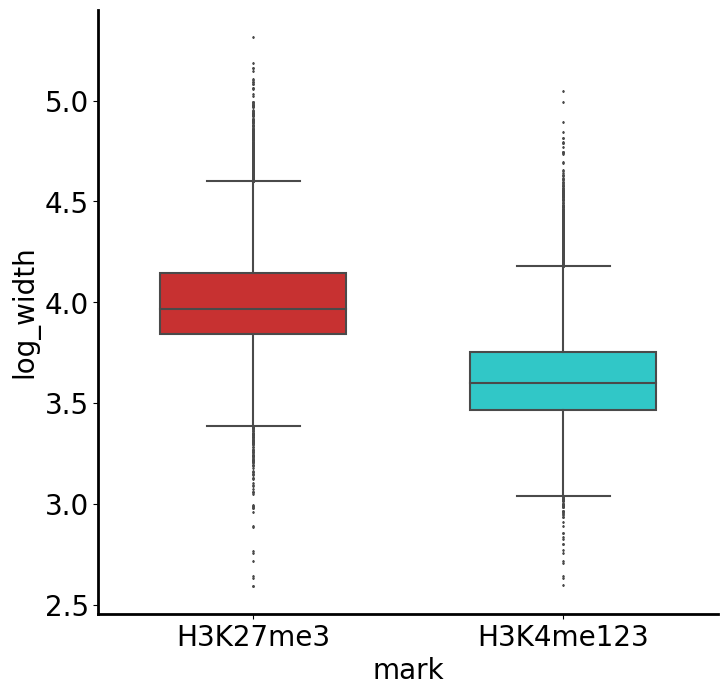

In [83]:
#merge
peaks = pd.concat([K27,K4])

#plot
sns.boxplot(
    data= peaks, 
    x='mark',
    y='log_width',
    width=0.6,
    fliersize  = 1,
    # linewidth = 1,
    palette = ['#c73131', '#31c7c7'],
    saturation  = 1 
)
plt.savefig(
    fig_dir + '230418_peak_widths.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)
plt.show()

In [76]:
t_stat, p_value = ttest_ind(K27['log_width'], K4['log_width'])
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  159.51881525090715
P-Value:  0.0


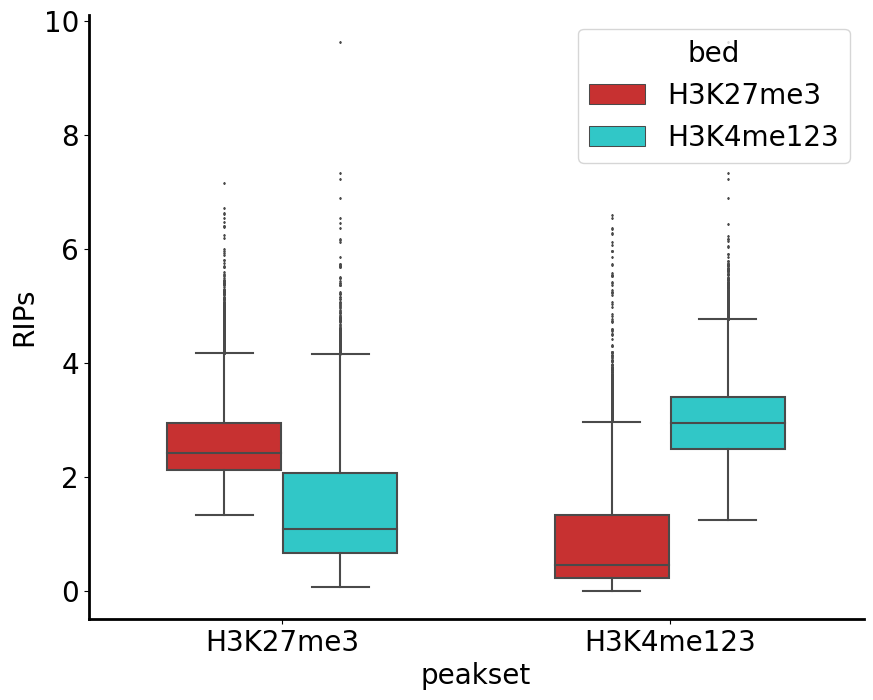

In [43]:
#reformat data
a = K27[['mark','mark','RIPs_K27']]
b = K27[['mark','bed','RIPs_K4']]
c = K4[['mark','mark','RIPs_K4']]
d = K4[['mark','bed','RIPs_K27']]

a.columns = ['peakset', 'bed', 'RIPs']
b.columns = ['peakset', 'bed', 'RIPs']
c.columns = ['peakset', 'bed', 'RIPs']
d.columns = ['peakset', 'bed', 'RIPs']

#concat
RIPs = pd.concat([a,b,c,d])
RIPs

matplotlib.rcParams['figure.figsize'] = [10, 8] # Square

#plot
sns.boxplot(
    data= RIPs, 
    x='peakset',
    y='RIPs',
    hue ='bed',
    hue_order = ['H3K27me3', 'H3K4me123'],
    width=0.6,
    fliersize  = 1,
    # linewidth = 1,
    palette = ['#c73131', '#31c7c7'],
    saturation  = 1 
)
plt.savefig(
    fig_dir + '230418_RIPs.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)
plt.show()

In [49]:
t_stat, p_value = ttest_rel(K27['RIPs_K27'], K27['RIPs_K4'])
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  213.58123406253526
P-Value:  0.0


In [48]:
t_stat, p_value = ttest_rel(K4['RIPs_K27'], K4['RIPs_K4'])
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -294.8386086871914
P-Value:  0.0


In [92]:
#import raw metadata
K27_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K27me3_220523_220527_79x79_MERGE_50k/proj_dirty_final/'
K4_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/ArchR/DJ_Hs_PBMC_K4me123_220523_220527_79x79_MERGE_50k/proj_dirty_final/'
K4_meta = pd.read_csv(K4_dir + 'cell_metadata.csv', index_col=0)
K27_meta = pd.read_csv(K27_dir + 'cell_metadata.csv', index_col=0)

In [112]:
K27_meta['genotype'].replace(['0', '1'], 'Single',inplace = True)
K4_meta['genotype'].replace(['0', '1'], 'Single',inplace = True)

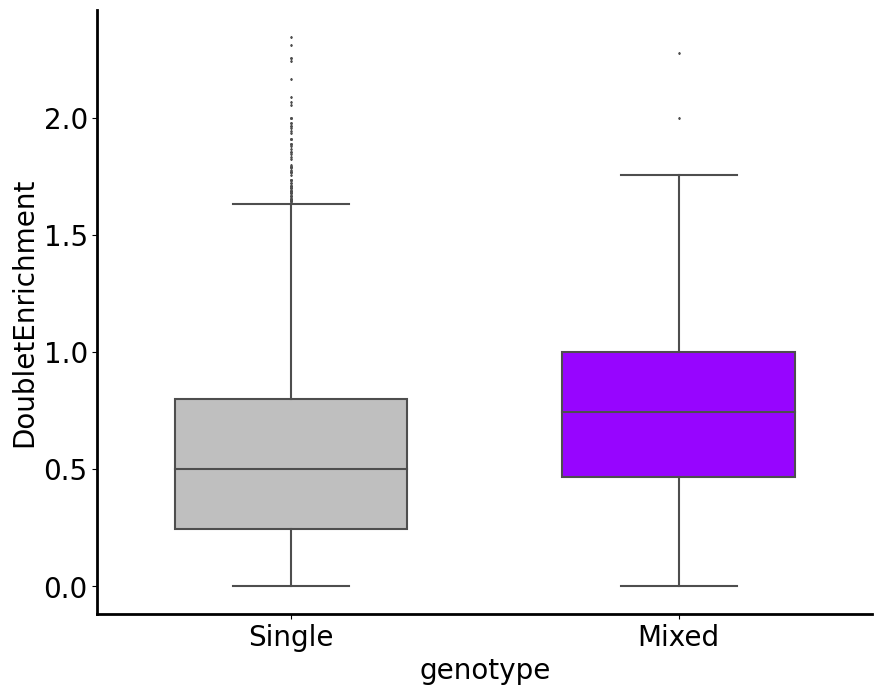

In [126]:
#plot
sns.boxplot(
    data= K27_meta, 
    x='genotype',
    y='DoubletEnrichment',
    width=0.6,
    fliersize  = 1,
    # linewidth = 1,
    order = ['Single', 'Mixed'],
    palette = ['#bfbfbf', '#9705ff'],
    saturation  = 1 
)
plt.savefig(
    fig_dir + '230425_K27_doublets_boxplot.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

In [117]:
K27_meta[K27_meta['genotype'] == 'Single']['DoubletEnrichment']

DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#AACGCCAT_GAACTCGA_AGCGATAG_CAGGACGT_DJ_Hs_PBMC_K27me3_DJnMM_0.25X_220527    0.766667
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#AGACCAGC_CCAGTTTA_AGCGATAG_TTCTCGTA_DJ_Hs_PBMC_K27me3_DJnMM_PE79_220523     0.566667
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#TTTAATGC_TGTTCCTG_AGCGATAG_TTCTCGTA_DJ_Hs_PBMC_K27me3_DJnMM_PE79_220523     0.655556
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#TTCCATAT_ACGCGCAG_CGGCTATG_TATAGCCT_DJ_Hs_PBMC_K27me3_MM_PE79_220523        1.166667
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#GACGCTCC_ATTGGGTC_AGCGATAG_CAGGACGT_DJ_Hs_PBMC_K27me3_DJnMM_0.25X_220527    0.844444
                                                                                                                     ...   
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#TAACAACA_ACCGGCCC_TCCGCGAA_ATAGAGGC_DJ_Hs_PBMC_K27me3_MM_1X_220527          0.000000
DJ_Hs_PBMC_K27me3_ALLSEQ_220523_220527#TAACAACA_TCACATGG_CTGAAGCT_ATAGAGGC_DJ_Hs_PBMC_K27me3_DJ_1X_220527          0.044444
DJ_Hs_PB

In [124]:
t_stat, p_value = sts.ttest_ind(
    K27_meta[K27_meta['genotype'] == 'Single']['DoubletEnrichment'], 
    K27_meta[K27_meta['genotype'] == 'Mixed']['DoubletEnrichment']
)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -11.100723323237643
P-Value:  1.5398519800535055e-28


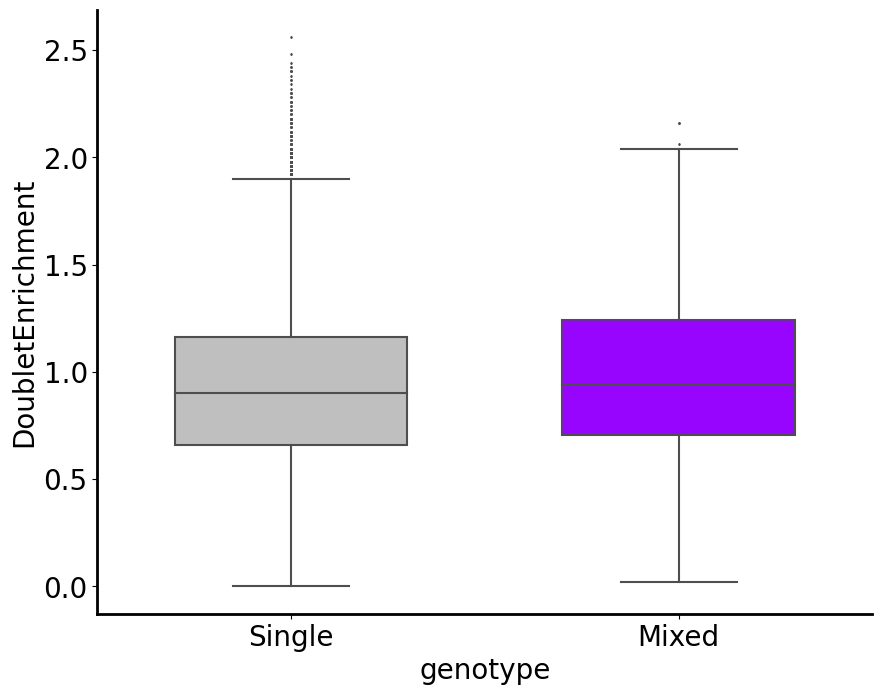

In [127]:
#plot
sns.boxplot(
    data= K4_meta, 
    x='genotype',
    y='DoubletEnrichment',
    width=0.6,
    fliersize  = 1,
    # linewidth = 1,
    order = ['Single', 'Mixed'],
    palette = ['#bfbfbf', '#9705ff'],
    saturation  = 1 
)
plt.savefig(
    fig_dir + '230425_K4_doublets_boxplot.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

In [125]:
t_stat, p_value = sts.ttest_ind(
    K4_meta[K4_meta['genotype'] == 'Single']['DoubletEnrichment'], 
    K4_meta[K4_meta['genotype'] == 'Mixed']['DoubletEnrichment']
)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -3.0723877353001665
P-Value:  0.002128816683622306
